In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.ml_utils import read_one_df, read_all_df, clean_data, transform_tohourdata, transform_todailydata

In [2]:
# load data
def load_data():
    data = read_one_df()
    data =  clean_data(data)
    data = transform_todailydata(data)
    data.drop(columns=['Yt_avg',	'Rs_avg',	'Rbt_avg',	'Rm_avg'], inplace=True)
    return data

data = load_data() 

In [4]:
data.describe()

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,P_avg
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,10.875349,1017.225291,79.025458,3.477724,172.108438,0.062491,0.001347,332.536519
std,6.937008,7.971215,13.383810,1.668870,64.228294,0.151186,0.014370,342.437588
min,-5.910000,981.125000,38.458333,1.020833,11.500000,0.000000,0.000000,-6.032708
25%,5.287292,1012.750000,69.052083,2.234688,122.375000,0.000000,0.000000,88.590990
50%,10.753993,1017.458333,81.354167,3.044167,183.895833,0.000000,0.000000,215.961562
75%,16.035937,1022.333333,89.781250,4.349687,221.666667,0.041927,0.000000,450.027708
max,29.057500,1042.041667,100.000000,14.297083,330.416667,1.822500,0.252500,2018.135695


Model


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

MM_scaler = MinMaxScaler()
Std_scaler = StandardScaler()

Rob_scaler = RobustScaler()

In [4]:
from utils.model_utils import pipeline_train

data_ml = pipeline_train(data, MM_scaler)

In [5]:
data_ml.head()

,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,wind_sin,wind_cos,year_sin,year_cos,P_avg
1356998400,0.320989,0.514364,0.806364,0.302514,0.182670,0.0,-0.537300,-0.843391,0.017213,0.999852,782.613541
1357084800,0.235290,0.757866,0.896412,0.166871,0.000000,0.0,-0.675590,-0.737277,0.034422,0.999407,160.549097
1357171200,0.300064,0.917921,0.921462,0.302514,0.022862,0.0,-0.493689,-0.869639,0.051620,0.998667,396.093055
1357257600,0.372096,0.930233,0.962085,0.142705,0.000000,0.0,-0.915311,-0.402747,0.068802,0.997630,117.150973
1357344000,0.330164,0.880985,0.905213,0.074820,0.000000,0.0,-0.788905,-0.614515,0.085965,0.996298,62.375833


  # lag features

In [6]:
from utils.model_utils import df_to_X_y

X, y = df_to_X_y(data_ml)

X.shape, y.shape

((1824, 2, 11), (1824,))

In [7]:
def split_data(X, y):
    X_train , y_train = X[ : 1459], y[ :1459 ]
    X_val, y_val = X[1459: ], y[1459: ]
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = split_data(X, y)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1459, 2, 11), (1459,), (365, 2, 11), (365,))

In [3]:
#plot function

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [9]:
def create_model():
    model = Sequential([
        InputLayer(shape=(2,11))
        , Conv1D(64, kernel_size=2, activation='relu')
        , Flatten()
        , Dense(8, 'relu')
        , Dense(1, 'linear')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse"
        , optimizer=opt
        , metrics=[keras.metrics.RootMeanSquaredError()]
        )

    return model

model = create_model()

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cp = ModelCheckpoint('models/model1.keras', save_best_only=True)
model.fit(
    X_train, y_train
    , validation_data= (X_val, y_val)
    , epochs = 5
    , callbacks=[cp]
)

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 103598.5391 - root_mean_squared_error: 321.8673 - val_loss: 102103.6641 - val_root_mean_squared_error: 319.5367
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85076.5625 - root_mean_squared_error: 291.6789 - val_loss: 95186.2500 - val_root_mean_squared_error: 308.5227
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84014.8828 - root_mean_squared_error: 289.8532 - val_loss: 95079.3125 - val_root_mean_squared_error: 308.3493
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84269.4062 - root_mean_squared_error: 290.2919 - val_loss: 96538.2891 - val_root_mean_squared_error: 310.7061
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83443.3672 - root_mean_squared_error: 288.8657 - val_loss: 91141.7500 - val_root_mean_squared_error: 301.8969


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(     Predictions      Actuals
 0      65.950706    82.372778
 1     114.168457    -0.761458
 2      47.503754    -3.422986
 3      62.668781    -4.777014
 4      55.810730    -5.425347
 ..           ...          ...
 360   919.313843  1092.846736
 361   790.118286   421.928542
 362   404.101227   854.138889
 363   624.265869  1435.234931
 364  1019.045044  1411.804653
 
 [365 rows x 2 columns],
 213.74833039683259)

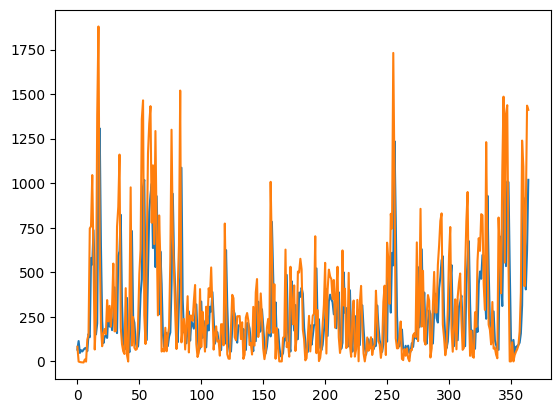

In [ ]:
plot_predictions(model, X_val, y_val)

In [5]:
def plot_predictions(model, X, y):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'])
    plt.plot(df['Actuals'])
    return df, mae(y, predictions)

In [4]:
from utils.model_utils import predict
model = load_model('models/model1.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<Axes: >

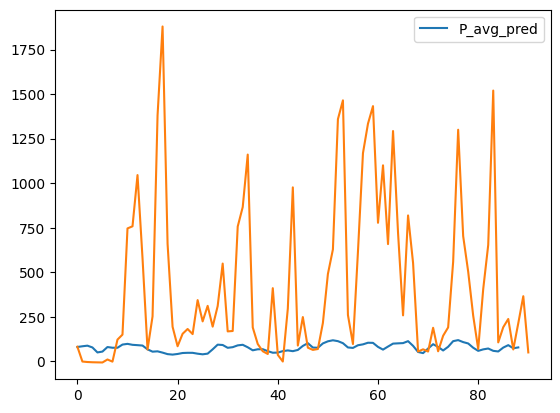

In [17]:
predict(data.loc[1483228800 : 1483228800 + 60*60*24*90], model).plot()
(data.loc[1483228800 :  1483228800 + 60*60*24*90,'P_avg']).reset_index(drop=1).plot()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<Axes: >

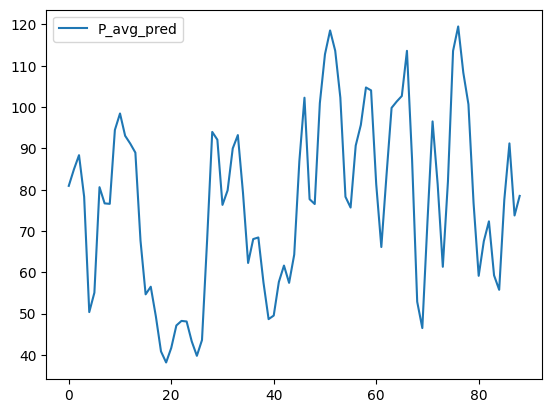

In [18]:
predict(data.loc[1483228800 : 1483228800 + 60*60*24*90], model).plot()

In [31]:
predictions

array([[ 238.75099],
       [ 319.54056],
       [ 153.62885],
       ...,
       [ 404.10123],
       [ 624.26587],
       [1019.04504]], shape=(1824, 1), dtype=float32)